In [1]:
# general purpose packages
import pandas as pd
import numpy as np

import os
from datetime import datetime
import pickle

# visualization related packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# generate random distributions for hyperparams
from scipy.stats import randint
from scipy.stats import beta
from scipy.stats import gamma
from scipy.stats import expon
from scipy.stats import uniform
from scipy.stats import poisson


# Classifier Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer

# data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize


# import model related packages
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold

from wordcloud import WordCloud
from sklearn.manifold import TSNE


from prettytable import PrettyTable

# Configs

In [2]:
sample_size = -1 # set -1 if we want to use full size # set fractional value for sample 

train_df_path = './data/Final_train_df.csv'
test_df_path = './data/Final_test_df.csv'

# Util Functions

In [3]:
def get_confusion_matrix(actual_list, predicted_list, title_suffix=str()):
    """
    This function plots the confusion matrix given ground truth and predicted
    """
    
    conf_matrix = confusion_matrix(actual_list, predicted_list, labels=[0, 1])
    
    col_names = ['Non Duplicate', 'Duplicate']
    conf_df = pd.DataFrame(conf_matrix, columns=col_names)
    conf_df.index = col_names
    
    # plot confusion matrix
    sns.heatmap(conf_df, annot=True, annot_kws={'size': 16}, fmt='g', cmap='YlGnBu',
                   cbar_kws={'label': 'prediction_count', 'format':'%d'})
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix -' + title_suffix)
    plt.show()
    
    return conf_df

In [4]:
def get_precision_recall_matrix(conf_matrix, title_suffix=str()):
    
    # compute precision matrix
    precision_matrix = conf_matrix.div(conf_matrix.sum(axis=0), axis=1) * 100.0
    
    # compute recall matrix
    recall_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0) * 100.0
    
    # plot both the matrices
    
    # plot precision matrix
    sns.heatmap(precision_matrix, annot=True, annot_kws={'size': 16}, fmt='.4f', cmap='YlGnBu',
                   cbar_kws={'label': 'percentage', 'format':'%.2f'})
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Precision Matrix -' + title_suffix)
    plt.show()
    
    # plot recall matrix
    sns.heatmap(recall_matrix, annot=True, annot_kws={'size': 16}, fmt='.4f', cmap='YlGnBu',
                   cbar_kws={'label': 'percentage', 'format':'%.2f'})
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Recall Matrix -' + title_suffix)
    plt.show()
    
    # return as a tuple
    return (precision_matrix, recall_matrix,)

In [5]:
def get_classification_report(actual, predicted, title_suffix=str()):
    
    # set class labels and its corresponding name
    class_labels_list = [0, 1]
    col_names = ['Non Duplicate', 'Duplicate']
    
    # compute performance df
    eval_matrix = precision_recall_fscore_support(actual, predicted, 
                                                  labels=class_labels_list)
    
    eval_df = pd.DataFrame(list(eval_matrix), columns=class_labels_list)
    eval_df.index = ['Precision', 'Recall', 'Fscore', 'Support']
    eval_df.columns = col_names
    
    
    # normalize the performace df
    eval_df_normed = eval_df * 100.0
    eval_df_normed.loc['Support', col_names] /= eval_df_normed.loc['Support', col_names].sum()
    eval_df_normed.iloc[3:4, :] *= 100.0
    
    # plot the classification report
    sns.heatmap(eval_df_normed, annot=True, annot_kws={'size': 16}, fmt='.4f', cmap='YlGnBu',
                   cbar_kws={'label': 'Percentage', 'format':'%.2f'})
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    
    plt.xlabel('Classes')
    plt.ylabel('Metrics')
    plt.title('Classification Report -' + title_suffix)
    plt.show()
    
    return eval_df_normed

In [6]:
def show_class_distribution(df, title):
    """
    This function displays the distribution of each class as a barchart
    """
    count_df = pd.DataFrame(list(dict(df['is_duplicate'].value_counts()).items()), 
                            columns=['is_duplicate', 'Count'])
    
    plt.title('Class Distribution of '+ title + ' Data')
    plt.xlabel('is_duplicate')
    plt.ylabel('Count')
    sns.barplot(x='is_duplicate', y =count_df['Count'], data=count_df)
    
    plt.show()

In [7]:
def evaluate_model(model, X, y):
    
    # get prediction and its probability
    predicted_labels = model.predict(X)
    predicted_probs = model.predict_proba(X)
    
    # get confsuion matrix
    conf_matrix = get_confusion_matrix(y, predicted_labels) 
    
    # get precision & recall matrix
    pre_matrix, recall_matrix = get_precision_recall_matrix(conf_matrix)
    
    # get classification report
    clf_report = get_classification_report(y, predicted_labels)
    
    # get the logistic loss
    log_loss_value = log_loss(y, predicted_probs, labels=[0, 1], eps=1e-15)
    log_loss_value = round(log_loss_value, 4)
    
    table_entry = (log_loss_value,)
    
    return table_entry

# Data

In [8]:
df_train = pd.read_csv(train_df_path, index_col=False)
df_test = pd.read_csv(test_df_path, index_col=False)

print('Shape of train data : ', df_train.shape)
print('Shape of test data :', df_test.shape)

if sample_size > 0:
    print('Sample is taken ', sample_size)
    # train sample
    df_train = df_train.sample(frac=sample_size)
    df_train = df_train.reset_index(drop=True)
    # test sample
    df_test = df_test.sample(frac=sample_size)
    df_test = df_test.reset_index(drop=True)
    
    print('Shape of train data : ', df_train.shape)
    print('Shape of test data :', df_test.shape)


Shape of train data :  (84000, 123)
Shape of test data : (36000, 123)


In [9]:
df_train.head()

,id,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,ctc_min,...,q2_start,q2_think,q2_time,q2_use,q2_want,q2_way,q2_without,q2_work,q2_would,q2_year
0,223477,0,73,61,12,13,2,23,0.086957,0.999999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,111372,0,32,40,6,6,3,12,0.250000,0.999998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,291123,0,67,46,13,10,2,22,0.090909,0.923076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,317134,1,33,37,7,6,4,13,0.307692,0.999999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,246990,0,94,58,16,10,1,25,0.040000,0.937499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
X_train = df_train.drop(['id', 'is_duplicate'], axis=1)
y_train = df_train['is_duplicate']

X_test = df_test.drop(['id', 'is_duplicate'], axis=1)
y_test = df_test['is_duplicate']

## Scale the data

In [11]:
col_names = X_train.columns.values.tolist()

# fit to data
std_scaler = StandardScaler()
std_scaler.fit(X_train)

# scale the datasets
X_train = pd.DataFrame(std_scaler.transform(X_train), columns=col_names)
X_test = pd.DataFrame(std_scaler.transform(X_test), columns=col_names)

X_train.head()

/home/nisheel-s/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nisheel-s/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/home/nisheel-s/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,ctc_min,ctc_max,cwc_min,...,q2_start,q2_think,q2_time,q2_use,q2_want,q2_way,q2_without,q2_work,q2_would,q2_year
0,0.449286,0.027934,0.195881,0.288942,-0.811405,0.222577,-1.061825,0.537775,0.537775,0.013822,...,-0.109526,-0.119748,-0.133215,-0.123439,-0.108397,-0.148691,-0.105842,-0.116595,-0.156094,-0.102217
1,-0.921050,-0.589063,-0.910307,-0.812989,-0.487533,-1.063037,0.207553,0.537762,0.537762,0.013725,...,-0.109526,-0.119748,-0.133215,-0.123439,-0.108397,-0.148691,-0.105842,-0.116595,-0.156094,-0.102217
2,0.248749,-0.412778,0.380245,-0.183314,-0.811405,0.105703,-1.031052,-0.637190,-0.637190,0.013876,...,-0.109526,-0.119748,-0.133215,-0.123439,-0.108397,-0.148691,-0.105842,-0.116595,-0.156094,-0.102217
3,-0.887627,-0.677205,-0.725942,-0.812989,-0.163660,-0.946163,0.656718,0.537765,0.537765,0.013725,...,-0.109526,-0.119748,-0.133215,-0.123439,-0.108397,-0.148691,-0.105842,-0.116595,-0.156094,-0.102217
4,1.151165,-0.060208,0.933339,-0.183314,-1.135278,0.456325,-1.427406,-0.416882,-0.416882,0.013846,...,-0.109526,-0.119748,-0.133215,-0.123439,-0.108397,-0.148691,-0.105842,-0.116595,-0.156094,-0.102217


# Model

In [12]:
def predict_using_random_model(df, df_type):

    # create a random prediction dataframe
    rand_df = pd.DataFrame(np.random.rand(df.shape[0], 2))

    # convert each row into a probability distribution
    rand_df = rand_df.div(rand_df.sum(axis=1), axis=0)
    
    # compute log loss
    log_loss_val = log_loss(df['is_duplicate'], rand_df.values, labels=[0,1] ,eps=1e-15)

    # get log loss on validation from the random model prediction
    print('Log loss on %s data using Random Model : %f'%(df_type, log_loss_val,))
    
    #return rand_df

In [13]:
predict_using_random_model(df_train, 'Train')
predict_using_random_model(df_test, 'Train')

Log loss on Train data using Random Model : 0.883145
Log loss on Train data using Random Model : 0.884132


## 1. Logistic Regression 

In [14]:
def get_best_hyperparam_LogisticRegression(param_dict, X, y, random_search=False):
    
    print(datetime.now() ,' Hyper param tuning of logistic regression started')
    
    # set the scoring function
    final_scorer = 'log_loss'
    
    # declare a scoring dictionary
    score_dict = {
        'log_loss': make_scorer(score_func=log_loss, greater_is_better=False,
                                needs_proba=True, needs_threshold=False,
                                eps=1e-15, labels=[0,1])
    }
        
    
     #Declare the metric as  'minimization' or 'maximization'
    optimization_dict = {
        'log_loss' : 'minimization'
    }
    
    
    # set data partitioning method
    cv_data = 3
        
     
    # declare model
    model = LogisticRegression()
    
    if random_search:
        search_cv = RandomizedSearchCV(estimator=model, param_distributions=param_dict, 
                                       cv=cv_data, scoring=score_dict, refit=False, 
                                       return_train_score=True, n_iter=6, n_jobs=-1)
        
    else:
        # declare grid search CV object
        search_cv = GridSearchCV(estimator=model, param_grid=param_dict, cv=cv_data,
                                 scoring=score_dict, refit=False, 
                                 return_train_score=True, n_jobs=-1)
    
    # fit to the data
    search_cv.fit(X, y)
    
    
    # get total number of param settings
    param_list = list(param_dict.keys())
    param_field_list = ['param_' + item for item in param_list]
    
    # get list of train metric list
    train_metric_list = ['mean_train_' + item for item in score_dict.keys()]
    # get list of test metric list
    test_metric_list = ['mean_test_' + item for item in score_dict.keys()]
    
    # get number of rows in the search cv data frame
    num_rows = len(search_cv.cv_results_['params'])
        
    # create the grid search info df  
    grid_info_df = pd.DataFrame(search_cv.cv_results_, index=range(num_rows))
    
    # prepare a list of reqired columns
    required_columns = ['params'] + param_field_list + train_metric_list + \
                       test_metric_list
    
    # slice the data frame to only required columns
    grid_info_df = grid_info_df[required_columns]
    
    # process individual metrics
    for metric, optimization in optimization_dict.items():
        if optimization == 'minimization':
            grid_info_df['mean_train_' + metric] *= -1
            grid_info_df['mean_test_' + metric] *= -1
            
    # Find the best hyperparam & its corresponding scores
    if optimization_dict[final_scorer] == 'minimization':
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmin(),:] 
    else:
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmax(),:]
        
    # best hyperparam & corresponding scores
    best_hyperparam = best_hyperparam_record['params']
    best_train_score = best_hyperparam_record['mean_train_'+ final_scorer]
    best_validation_score = best_hyperparam_record['mean_test_'+ final_scorer]
    
    # plot the hyper params 
    if len(param_list) == 1:
        
        # extract individual fiedls
        x_vals = np.log10(grid_info_df[param_field_list[0]].tolist())
        y_vals_tr = grid_info_df['mean_train_' + final_scorer].tolist()
        y_vals_val = grid_info_df['mean_test_' + final_scorer].tolist()
        
        # plot train, validation performances
        plt.plot(x_vals, y_vals_tr, label='Train', color='r', marker='o', linestyle='-')
        plt.plot(x_vals, y_vals_val, label='Validation', color='b', marker='o', linestyle='-')
        plt.xlabel('Log Hyper Params -' + param_list[0])
        plt.ylabel(final_scorer)
        plt.legend()
        plt.title('LogisticRegression - Hyperparam Train v/s Validation Scores')
        plt.show()
        
        
    # Heatmap plot for pair of hyperparam values  
    elif len(param_list) == 2:
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_train_' + final_scorer , 
                                      fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('LogisticRegression - Hyperparams Scores - Train')
        plt.show()
        
        print('\n'*3)
        
        # Test hyperparam
        
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_test_' + final_scorer, fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('LogisticRegression - Hyperparams Scores - Validation')
        plt.show()
        
    else:
        print(grid_info_df)
    
    print('Best hyperparam value: ', best_hyperparam, 'Best Train Score: ', best_train_score, 
          'Best Validation Score: ', best_validation_score)
   
          
    #best_mse_train = best_hyperparam_record['mean_train_MSE']
    #best_mse_validation = best_hyperparam_record['mean_test_MSE']
    
    # return tuple
    ret_tuple = (best_hyperparam, best_train_score, best_validation_score,)
    
    
    print(datetime.now() ,' Hyper param tuning of logistic regression Completed')
    
    
    return ret_tuple

### 1. Find best hyperparameter

2019-06-26 14:36:52.765010  Hyper param tuning of logistic regression started


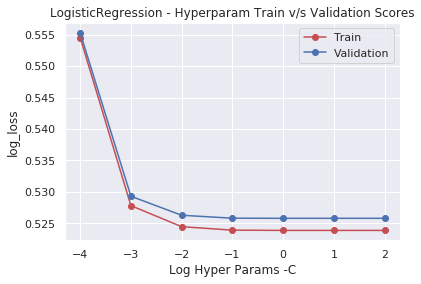

Best hyperparam value:  {'C': 1.0} Best Train Score:  0.523874261103707 Best Validation Score:  0.5257976568216084
2019-06-26 14:37:51.933136  Hyper param tuning of logistic regression Completed


In [15]:
# declare a set of params to search for
param_dict_lr = {'C' : [1e-04, 1e-03, 1e-02, 1e-01, 1e+00, 1e+01, 1e+02]}

hyp_tuned_info = get_best_hyperparam_LogisticRegression(param_dict_lr, X_train, 
                                                        y_train, False)
best_hyp_lr, best_tr_score_lr, best_val_score_lr = hyp_tuned_info
lr_clf = LogisticRegression(C=best_hyp_lr['C'])

### 2. Train the model with best hyperparameter

In [16]:
# train the model using the best hyperparam obtained
print(datetime.now() ,' Training of logistic regression started')
sig_lr_clf = CalibratedClassifierCV(base_estimator=lr_clf, method='sigmoid', cv=3)
sig_lr_clf.fit(X_train, y_train)
print(datetime.now() ,' Training of logistic regression Completed')

# save model to disk
pickle_out = open("./model/logistic_regression.pkl","wb")
pickle.dump(sig_lr_clf, pickle_out)
pickle_out.close()

2019-06-26 14:37:51.941957  Training of logistic regression started


/home/nisheel-s/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nisheel-s/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nisheel-s/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2019-06-26 14:38:16.352678  Training of logistic regression Completed


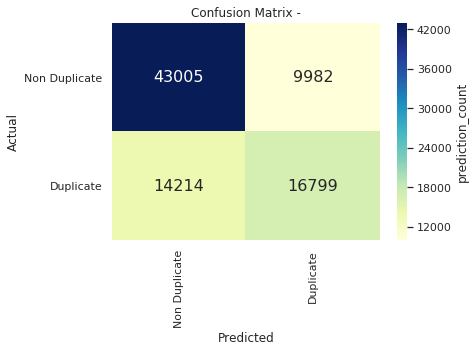

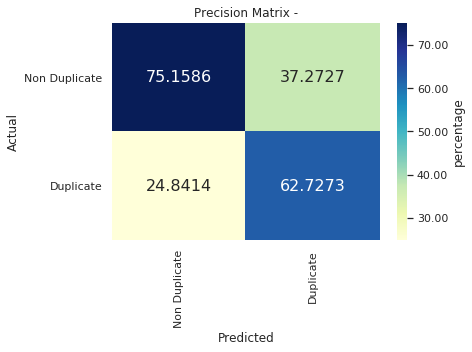

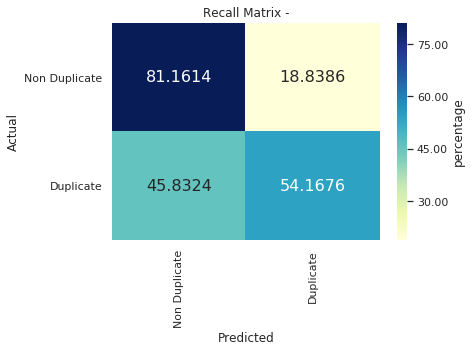

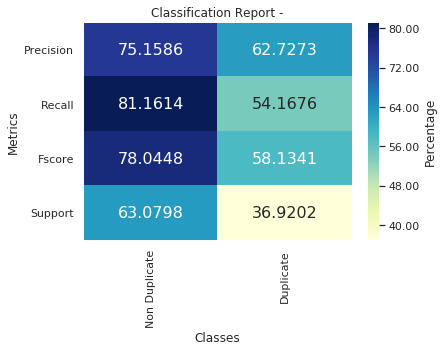

In [17]:
# get table entry for training data
#load model from disk
pickle_in = open("./model/logistic_regression.pkl","rb")
sig_lr_clf = pickle.load(pickle_in)
pickle_in.close()
table_entry_lr_train = evaluate_model(sig_lr_clf, X_train, y_train)

### 3. Test the model

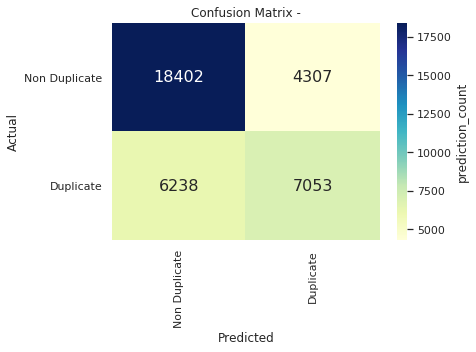

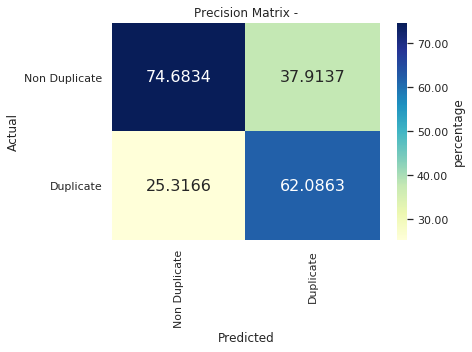

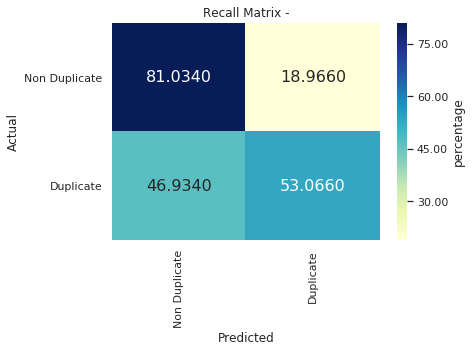

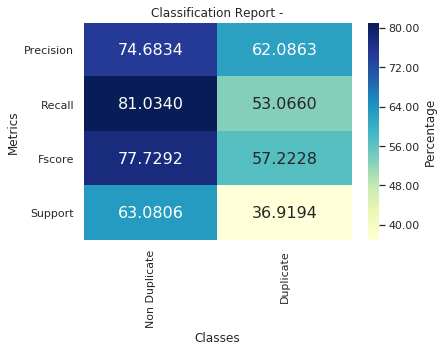

In [18]:
table_entry_lr_test = evaluate_model(sig_lr_clf, X_test, y_test)

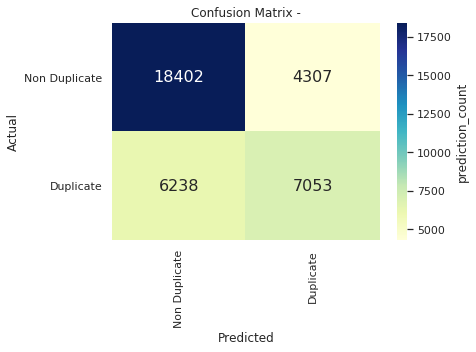

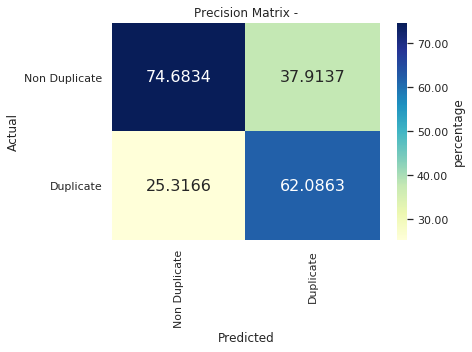

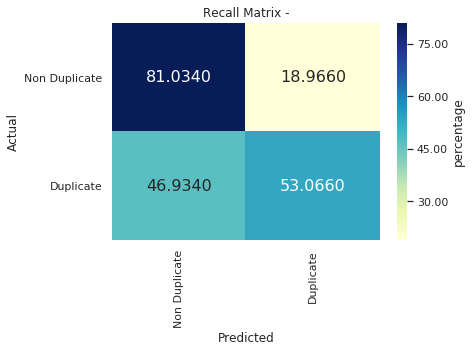

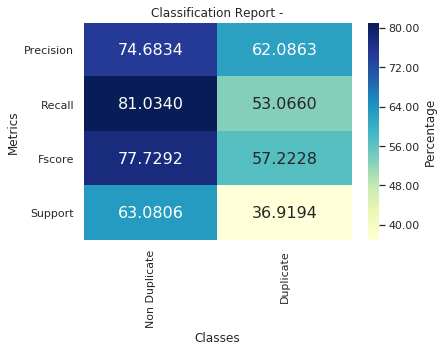

In [19]:
table_entry_lr_test = evaluate_model(sig_lr_clf, X_test, y_test)
table_entry_lr = ('Logistic Regression', best_hyp_lr,) + table_entry_lr_train + table_entry_lr_test

## 2. Linear SVM Classifier

In [20]:
def get_best_hyperparam_SVM_Classifier(param_list, X, y):
    
    print(datetime.now() ,' Hyperparam tuning of SVM started')
    
    # set the scoring function
    final_scorer = 'log_loss'
    

    # set data partitioning method
    cv_data = 3
    
    # set stratified K fold validation
    skf = StratifiedKFold(n_splits=cv_data)
    
    #declare two list for holding the loss for train, validation
    tr_loss_all = list()
    val_loss_all = list()
    
    for alpha_val in param_list:
        
        # declare model
        model = SGDClassifier(loss='hinge', alpha=alpha_val, tol=1e-03, 
                              max_iter=1e+03, penalty='l2', n_jobs=-1)
        
        # decalre calibrated classifier
        calib_model = CalibratedClassifierCV(base_estimator=model, 
                                             method='sigmoid',
                                             cv='prefit')
        
        # declare two lists for train, validation loss for each fold
        train_loss_list = list()
        val_loss_list = list()
        
        # evaluate for each fold
        for train_index, val_index in skf.split(X, y):
            
            # get train test split for this fold
            X_train, X_val = X.loc[train_index,:], X.loc[val_index,:]
            y_train, y_val = y[train_index], y[val_index]
            
            # fit to data
            model.fit(X_train, y_train)
            calib_model.fit(X_val, y_val)
        
            # get train, test log loss
            tr_probs = calib_model.predict_proba(X_train)
            val_probs = calib_model.predict_proba(X_val)
            
            # insert into log loss list
            train_loss_list.append(log_loss(y_train, tr_probs,
                                            labels=[0,1], eps=1e-15))
            val_loss_list.append(log_loss(y_val, val_probs, 
                                          labels=[0,1], eps=1e-15))
    
        # compute mean loss values
        mean_tr_loss = np.mean(train_loss_list)
        mean_val_loss = np.mean(val_loss_list)
        
        # update the lists
        tr_loss_all.append(mean_tr_loss)
        val_loss_all.append(mean_val_loss)
    
    # get total number of param settings
    # get number of rows in the search cv data frame
    num_rows = len(param_list)
        
    # create the grid search info df 
    cv_results_dict = {'alpha': param_list,
                       'mean_train_log_loss': tr_loss_all,
                       'mean_test_log_loss': val_loss_all}
    
    grid_info_df = pd.DataFrame(cv_results_dict, index=range(num_rows))
    
    # prepare a list of reqired columns
    required_columns = ['alpha', 'mean_train_log_loss', 
                        'mean_test_log_loss']
    
    # slice the data frame to only required columns
    grid_info_df = grid_info_df[required_columns]
    
        
    # Find the best hyperparam & its corresponding scores
    best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmin(),:] 
        
    # best hyperparam & corresponding scores
    best_hyperparam = {'alpha':best_hyperparam_record['alpha']}
    best_train_score = best_hyperparam_record['mean_train_'+ final_scorer]
    best_validation_score = best_hyperparam_record['mean_test_'+ final_scorer]
    
    # plot the hyper params 
    # extract individual fiedls
    x_vals = np.log10(param_list)
    y_vals_tr = grid_info_df['mean_train_' + final_scorer].tolist()
    y_vals_val = grid_info_df['mean_test_' + final_scorer].tolist()

    # plot train, validation performances
    plt.plot(x_vals, y_vals_tr, label='Train', color='r', marker='o', linestyle='-')
    plt.plot(x_vals, y_vals_val, label='Validation', color='b', marker='o', linestyle='-')
    plt.xlabel('Log Hyper Params - Alpha')
    plt.ylabel(final_scorer)
    plt.legend()
    plt.title('SVM Classifier - Hyperparam Train v/s Validation Scores')
    plt.show()
        
    print('Best hyperparam value: ', best_hyperparam, 'Best Train Score: ', best_train_score, 
          'Best Validation Score: ', best_validation_score)
   
          
    # return tuple
    ret_tuple = (best_hyperparam, best_train_score, best_validation_score,)
    
    print(datetime.now() ,' Hyperparam tuning of SVM completed')
    
    
    return ret_tuple

### 1. Find best hyperparameter

2019-06-26 14:38:18.633282  Hyperparam tuning of SVM started


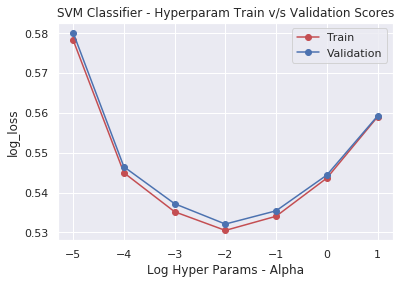

Best hyperparam value:  {'alpha': 0.01} Best Train Score:  0.5305024792875814 Best Validation Score:  0.532101941778017
2019-06-26 14:38:52.919826  Hyperparam tuning of SVM completed


In [21]:
# declare a set of params to search for
param_list_svm = [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1e+00, 1e+01]

hyp_tuned_info = get_best_hyperparam_SVM_Classifier(param_list_svm, X_train, 
                                                    y_train)
best_hyp_svm, best_tr_score_svm, best_val_score_svm = hyp_tuned_info

svm_clf = SGDClassifier(loss='hinge', alpha=best_hyp_svm['alpha'], tol=1e-03, 
                        max_iter=1e+03, penalty='l2', n_jobs=-1)

svm_sig_clf = CalibratedClassifierCV(base_estimator=svm_clf, 
                                     method='sigmoid', cv=3)

### 2. Train the model with best hyperparameter

In [22]:
# train the model using the best hyperparam obtained
print(datetime.now() ,' Training of SVM started')
svm_sig_clf.fit(X_train, y_train)
print(datetime.now() ,' Training of SVM completed')

# save model to disk
pickle_out = open("./model/svm.pkl","wb")
pickle.dump(svm_sig_clf, pickle_out)
pickle_out.close()

2019-06-26 14:38:52.930837  Training of SVM started
2019-06-26 14:38:54.522214  Training of SVM completed


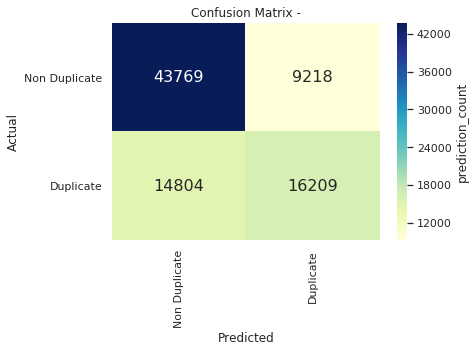

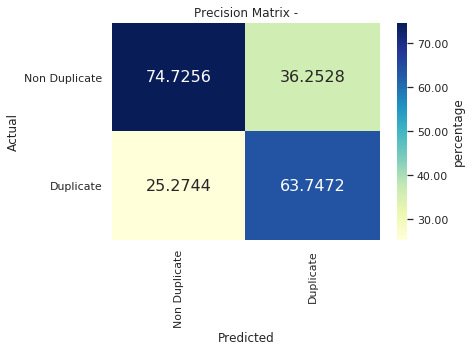

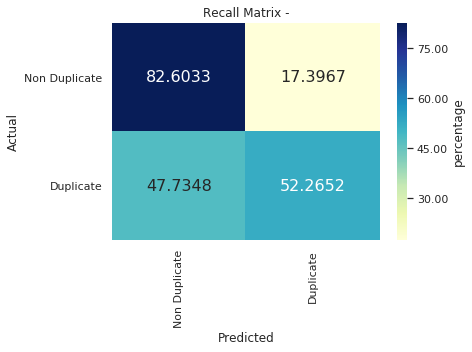

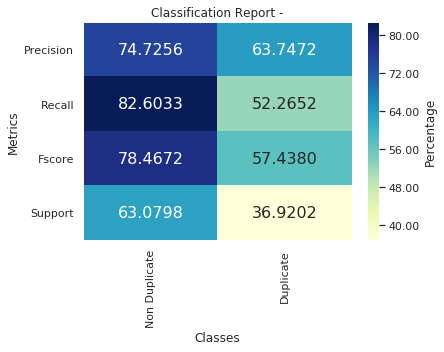

In [23]:
pickle_in = open("./model/svm.pkl","rb")
svm_sig_clf = pickle.load(pickle_in)
pickle_in.close()
table_entry_svm_train = evaluate_model(svm_sig_clf, X_train, y_train)

### 3. Test the model

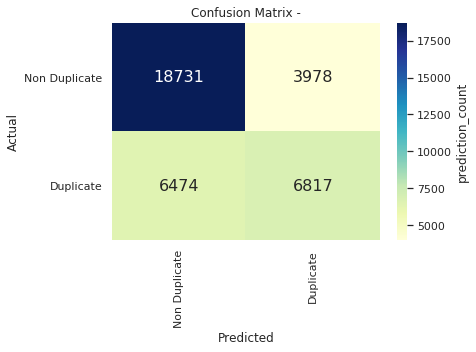

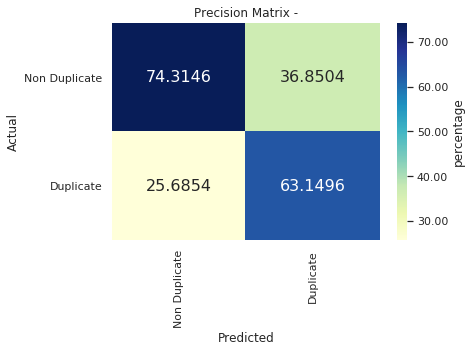

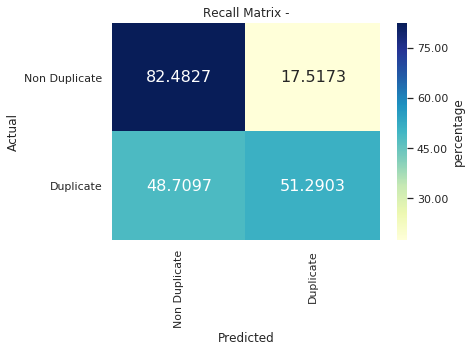

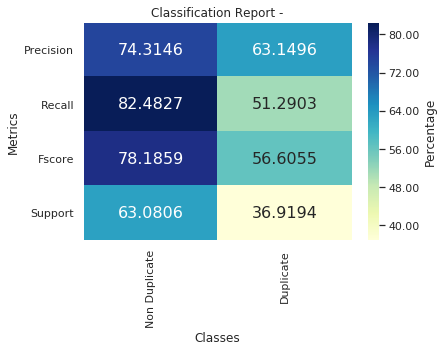

In [24]:
table_entry_svm_test = evaluate_model(svm_sig_clf, X_test, y_test)
table_entry_svm = ('Linear SVM', best_hyp_svm,) + table_entry_svm_train + table_entry_svm_test

## 3. XG Boost Classifier

In [25]:
def get_best_hyperparam_XGBClassifier(param_dict, X, y, random_search=False):
    
    print(datetime.now() ,' Hyperparam Tuning of XGB started')
    
    # set the scoring function
    final_scorer = 'log_loss'
    
    # declare a scoring dictionary
    score_dict = {
        'log_loss': make_scorer(score_func=log_loss, greater_is_better=False,
                                needs_proba=True, needs_threshold=False,
                                eps=1e-15, labels=[0,1])
    }
        
    
     #Declare the metric as  'minimization' or 'maximization'
    optimization_dict = {
        'log_loss' : 'minimization'
    }
    
    # set data partitioning method
    cv_data = 3
    
    # declare model
    model = XGBClassifier()
    
    if random_search:
        search_cv = RandomizedSearchCV(estimator=model, param_distributions=param_dict, 
                                       cv=cv_data, scoring=score_dict, refit=False, 
                                       return_train_score=True, n_iter=6, n_jobs=-1)
        
    else:
        # declare grid search CV object
        search_cv = GridSearchCV(estimator=model, param_grid=param_dict, cv=cv_data,
                                 scoring=score_dict, refit=False, 
                                 return_train_score=True, n_jobs=-1)
    
    # fit to the data
    search_cv.fit(X, y)
    
    
    # get total number of param settings
    param_list = list(param_dict.keys())
    param_field_list = ['param_' + item for item in param_list]
    
    # get list of train metric list
    train_metric_list = ['mean_train_' + item for item in score_dict.keys()]
    # get list of test metric list
    test_metric_list = ['mean_test_' + item for item in score_dict.keys()]
    
    # get number of rows in the search cv data frame
    num_rows = len(search_cv.cv_results_['params'])
        
    # create the grid search info df  
    grid_info_df = pd.DataFrame(search_cv.cv_results_, index=range(num_rows))
    
    # prepare a list of reqired columns
    required_columns = ['params'] + param_field_list + train_metric_list + \
                       test_metric_list
    
    # slice the data frame to only required columns
    grid_info_df = grid_info_df[required_columns]
    
    # process individual metrics
    for metric, optimization in optimization_dict.items():
        if optimization == 'minimization':
            grid_info_df['mean_train_' + metric] *= -1
            grid_info_df['mean_test_' + metric] *= -1
            
    # Find the best hyperparam & its corresponding scores
    if optimization_dict[final_scorer] == 'minimization':
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmin(),:] 
    else:
        best_hyperparam_record = grid_info_df.loc[grid_info_df[
                                   'mean_test_'+ final_scorer].idxmax(),:]
        
    # best hyperparam & corresponding scores
    best_hyperparam = best_hyperparam_record['params']
    best_train_score = best_hyperparam_record['mean_train_'+ final_scorer]
    best_validation_score = best_hyperparam_record['mean_test_'+ final_scorer]
    
    # plot the hyper params 
    if len(param_list) == 1:
        
        # extract individual fiedls
        x_vals = grid_info_df[param_field_list[0]].tolist()
        y_vals_tr = grid_info_df['mean_train_' + final_scorer].tolist()
        y_vals_val = grid_info_df['mean_test_' + final_scorer].tolist()
        
        # plot train, validation performances
        plt.plot(x_vals, y_vals_tr, label='Train', color='r', marker='o', linestyle='-')
        plt.plot(x_vals, y_vals_val, label='Validation', color='b', marker='o', linestyle='-')
        plt.xlabel('Hyper Params -' + param_list[0])
        plt.ylabel(final_scorer)
        plt.legend()
        plt.title('XGB Classifier - Hyperparam Train v/s Validation Scores')
        plt.show()
        
        
    # Heatmap plot for pair of hyperparam values  
    elif len(param_list) == 2:
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_train_' + final_scorer , 
                                      fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('XGB Classifier - Hyperparams Scores - Train')
        plt.show()
        
        print('\n'*3)
        
        # Test hyperparam
        
        # get pivoted table
        train_hyp_df = pd.pivot_table(data=grid_info_df, index=param_field_list[0], 
                                      columns=param_field_list[1],
                                      values='mean_test_' + final_scorer, fill_value=np.inf)
        sns.heatmap(train_hyp_df, annot=True, cmap='YlGnBu', fmt='.4f',
                   cbar_kws={'label': final_scorer, 'format':'%.2f'})
        plt.xlabel(param_list[1])
        plt.ylabel(param_list[0])
        plt.title('XGB Classifier - Hyperparams Scores - Validation')
        plt.show()
        
    else:
        print(grid_info_df)
    
    print('Best hyperparam value: ', best_hyperparam, 'Best Train Score: ', best_train_score, 
          'Best Validation Score: ', best_validation_score)
   
          
    #best_mse_train = best_hyperparam_record['mean_train_MSE']
    #best_mse_validation = best_hyperparam_record['mean_test_MSE']
    
    # return tuple
    ret_tuple = (best_hyperparam, best_train_score, best_validation_score,)
    
    print(datetime.now() ,' Hyperparam Tuning of XGB completed')
    
    
    return ret_tuple

### 1. Find best hyperparameter

2019-06-26 14:38:55.850678  Hyperparam Tuning of XGB started


/home/nisheel-s/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


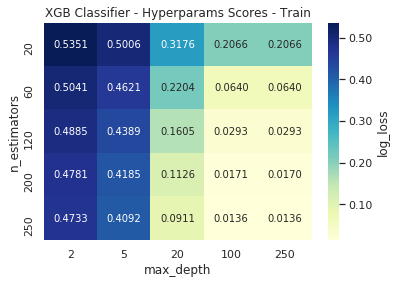

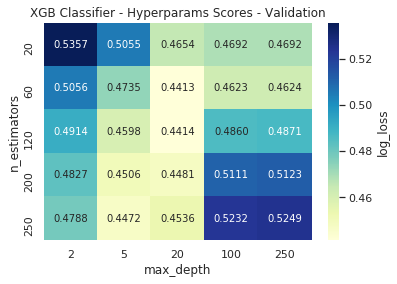

Best hyperparam value:  {'max_depth': 20, 'n_estimators': 60} Best Train Score:  0.22042729628256752 Best Validation Score:  0.4412671148089631
2019-06-26 15:58:46.269411  Hyperparam Tuning of XGB completed


In [26]:
# declare a set of params to search for
param_dict_xgb = {'n_estimators' : [20, 60, 120, 200, 250],
                  'max_depth' : [2, 5, 20, 100, 250]
                 }

hyp_tuned_info = get_best_hyperparam_XGBClassifier(param_dict_xgb, X_train, 
                                                   y_train, False)
best_hyp_xgb, best_tr_score_xgb, best_val_score_xgb = hyp_tuned_info

xgb_clf = XGBClassifier(n_estimators=best_hyp_xgb['n_estimators'], 
                            max_depth=best_hyp_xgb['max_depth'])

xgb_sig_clf = CalibratedClassifierCV(base_estimator=xgb_clf, method='sigmoid', cv=3)

### 2. Train the model with best hyperparameter

In [27]:
# train the model using the best hyperparam obtained
print(datetime.now() ,' Training of XGB started')
xgb_sig_clf.fit(X_train, y_train)
print(datetime.now() ,' Training of XGB completed')

# save model to disk
pickle_out = open("./model/xgb.pkl","wb")
pickle.dump(xgb_sig_clf, pickle_out)
pickle_out.close()

2019-06-26 15:58:46.280307  Training of XGB started
2019-06-26 16:01:21.236148  Training of XGB completed


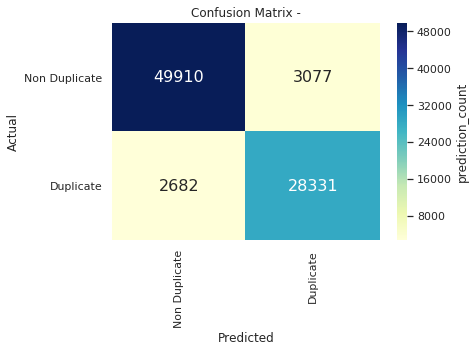

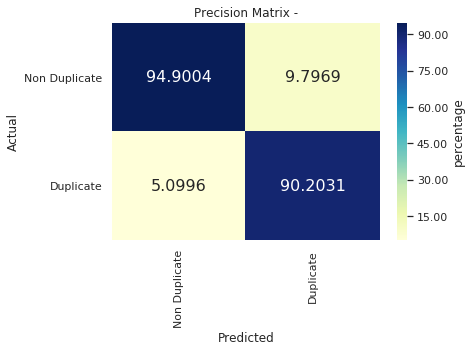

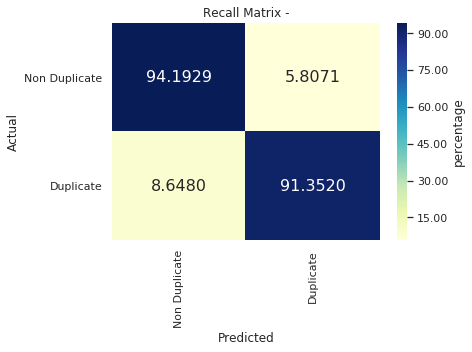

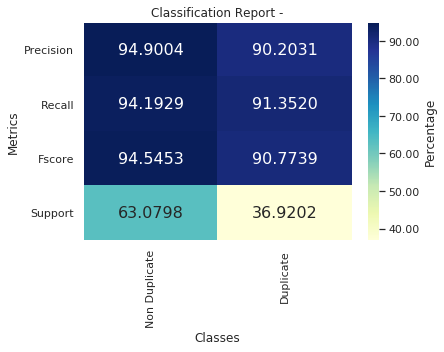

In [28]:
pickle_in = open("./model/xgb.pkl","rb")
xgb_sig_clf = pickle.load(pickle_in)
pickle_in.close()
table_entry_xgb_train = evaluate_model(xgb_sig_clf, X_train, y_train)

### 3. Test the model

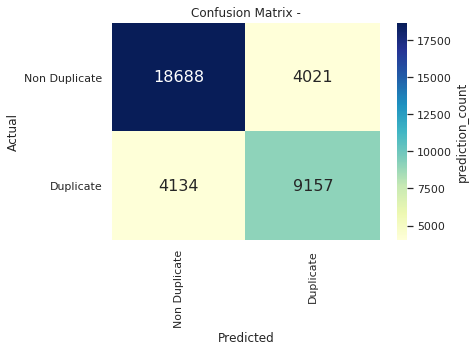

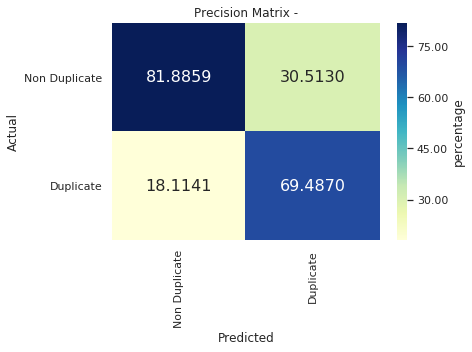

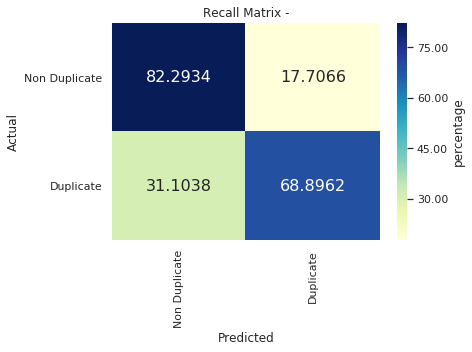

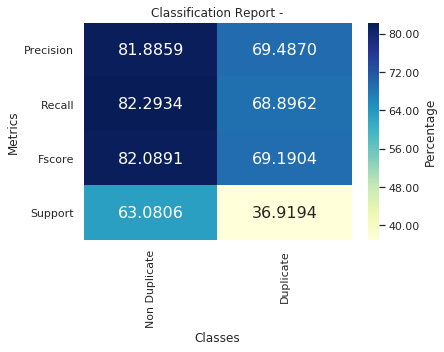

In [29]:
table_entry_xgb_test = evaluate_model(xgb_sig_clf, X_test, y_test)
best_hyp_xgb = '\n'.join(str(best_hyp_xgb).split(','))
table_entry_xgb = ('XG Boost', best_hyp_xgb,) + table_entry_xgb_train + table_entry_xgb_test

# Results

In [30]:
Pret_table = PrettyTable()
Pret_table.field_names = ['Model', 'Hyperparam', 'Train_Log_Loss', 'Test_Log_Loss']
Pret_table.title = 'Classification Model Results Summary'

# enter model performance metrics
Pret_table.add_row(table_entry_lr)
Pret_table.add_row(table_entry_svm)
Pret_table.add_row(table_entry_xgb)
print(Pret_table)

+---------------------+----------------------+----------------+---------------+
|        Model        |      Hyperparam      | Train_Log_Loss | Test_Log_Loss |
+---------------------+----------------------+----------------+---------------+
| Logistic Regression |      {'C': 1.0}      |     0.5242     |     0.5313    |
|      Linear SVM     |   {'alpha': 0.01}    |     0.5301     |     0.5372    |
|       XG Boost      |   {'max_depth': 20   |     0.2753     |     0.4493    |
|                     |  'n_estimators': 60} |                |               |
+---------------------+----------------------+----------------+---------------+


# Procedure Summary

<ul>
<li> Three ML models (LogisticRegression, LinearSVM, XGB) are used to solve the problem </li>
<li> Hyperparam  tuning of all models done </li>
<li> All models are trained with the best hyperparam values </li>
<li> The performacne of each model is evaluated on a test set </li>
</ul>

# Conclusion

<ul>
<li> The best log loss obtained is for XGB model (0.4493)</li>
<li> The XGB model showed a tendency to overfit due to quiet large deviation of loss between train test data</li>
<li> More feature engineering methods can be tried to imporove the results further</li>
<li> The f1-score for XGB test is 69.19 % , and SVM - 56.70%, Logistic regression- 57.22% </li>
<li> XGB model outperformed other models interms of f1-score </li>
</ul>